In [1]:
from IPython.display import HTML
from IPython.display import display

display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import statsmodels, statsmodels.api as sm
import sympy, sympy.stats
import pymc3 as pm
import daft

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

SEED = 42
np.random.seed(SEED)

sns.set()

This blog post is part of the [Series: Monte Carlo Methods](https://weisser-zwerg.dev/posts/series-monte-carlo-methods/).

You can find this blog post on [weisser-zwerg.dev](https://weisser-zwerg.dev/posts/monte-carlo-fundamental-concepts/), [github](https://github.com/cs224/blog-series-monte-carlo-methods) and [nbviewer](https://nbviewer.jupyter.org/github/cs224/blog-series-monte-carlo-methods/blob/main/0010-fundamental-concepts.ipynb?flush_cache=true).

# Monte Carlo Fundamental Concepts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Boundary-between-statistics-and-machine-learning-/-AI" data-toc-modified-id="Boundary-between-statistics-and-machine-learning-/-AI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Boundary between statistics and machine learning / AI</a></span></li><li><span><a href="#Statistical-Models" data-toc-modified-id="Statistical-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statistical Models</a></span></li><li><span><a href="#How-to-construct-models:-keep-the-Bayes'-theorem-and-the-law-of-total-probability-(extending-the-conversation)-always-in-mind" data-toc-modified-id="How-to-construct-models:-keep-the-Bayes'-theorem-and-the-law-of-total-probability-(extending-the-conversation)-always-in-mind-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>How to construct models: keep the Bayes' theorem and the law of total probability (extending the conversation) always in mind</a></span><ul class="toc-item"><li><span><a href="#Bayes'-theorem" data-toc-modified-id="Bayes'-theorem-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Bayes' theorem</a></span></li><li><span><a href="#Law-of-total-probability-(extending-the-conversation)" data-toc-modified-id="Law-of-total-probability-(extending-the-conversation)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Law of total probability (extending the conversation)</a></span></li></ul></li><li><span><a href="#What-is-the-&quot;right&quot;-representation-of-(multi-dimensional)-probability-distributions?" data-toc-modified-id="What-is-the-&quot;right&quot;-representation-of-(multi-dimensional)-probability-distributions?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>What is the "right" representation of (multi-dimensional) probability distributions?</a></span></li><li><span><a href="#Operations-on-probability-distributions:-marginalization-and-conditional-probability" data-toc-modified-id="Operations-on-probability-distributions:-marginalization-and-conditional-probability-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Operations on probability distributions: marginalization and conditional probability</a></span></li><li><span><a href="#Calculations-with-random-variables:-convolutions-and-other-nasty-stuff" data-toc-modified-id="Calculations-with-random-variables:-convolutions-and-other-nasty-stuff-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculations with random variables: convolutions and other nasty stuff</a></span></li><li><span><a href="#Density-Estimation" data-toc-modified-id="Density-Estimation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Density Estimation</a></span></li><li><span><a href="#The-algorithm-has-to-always-perform-the-same-heavy-lifting:-there-is-no-ancestral-sampling" data-toc-modified-id="The-algorithm-has-to-always-perform-the-same-heavy-lifting:-there-is-no-ancestral-sampling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>The algorithm has to always perform the same heavy lifting: there is no ancestral sampling</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Examples-of-mixed-discrete-continuous-probability-functions" data-toc-modified-id="Examples-of-mixed-discrete-continuous-probability-functions-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Examples of mixed discrete continuous probability functions</a></span><ul class="toc-item"><li><span><a href="#Two-independent-dice-rolls" data-toc-modified-id="Two-independent-dice-rolls-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>Two independent dice rolls</a></span></li><li><span><a href="#Two-component-mixture-model" data-toc-modified-id="Two-component-mixture-model-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>Two component mixture model</a></span></li></ul></li></ul></li></ul></div>

## Boundary between statistics and machine learning / AI

Only very recently I found the work of 2010 [Turing Award](https://en.wikipedia.org/wiki/Turing_Award) winner [Leslie Valiant](https://en.wikipedia.org/wiki/Leslie_Valiant). In his book [Probably Approximately Correct](https://www.amazon.com/Probably-Approximately-Correct-Algorithms-Prospering/dp/0465060722/) he defines the two concepts **theoryful** and **theoryless**. This would be the place where I would draw the line between statistics and machine learning.

Theoryful: a human has to provide a model and there may be some data that helps to tune the model. A good example would be newtonian motion of the planets around the sun where Newton's laws provide the model and the data helps to pinpoint the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant).

Theoryless: you take a very generic algorithm and a lot of data and the algorithm figures out the rest. A good example would be a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) and pictures of objects, where the algorithm learns via data to identify the objects. The same multilayer perceptron architecture could be used to pilot a self driving car.

## Statistical Models

In (bayesian) statistics a model is basically a **total** [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function) (PMF; in the discrete case) or a [probiability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF; in the continuous case). It comes often in the form of a [probabilistic graphical model](https://en.wikipedia.org/wiki/Graphical_model) (PGM; also see [Bayesian hierarchical model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)). As an example you see below the graphical representation of multiple coin tosses using the same coin:

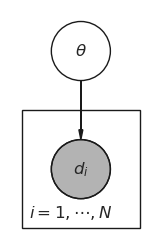

In [3]:
pgm = daft.PGM(grid_unit=3.0, node_unit=1.5)

pgm.add_node("theta", r"$\theta$", 0, 2)
pgm.add_node("d", r"$d_i$", 0, 1, observed=True)
pgm.add_plate([-0.5, 0.5, 1.0, 1.0], label=r"$i = 1, \cdots, N$")#, shift=-0.1

pgm.add_edge("theta", "d")

pgm.render(dpi=100);

In standard mathematical notation this would be:

$\displaystyle
\begin{array}{rcl}
p(\theta) &=& \mathrm{Beta}(\alpha=1,\beta=1) \\
p(X_i=d_i\,|\,\theta) &=& \mathrm{Bernoulli}(X_i=d_i;p=\theta) \\
\displaystyle p(X_1=d_1, X_2 = d_2, ..., X_n = d_n, \theta)&=& \displaystyle p(\theta) \cdot\prod_{i=1}^N p(X_i=d_i\,|\,\theta)
\end{array}
$

Where on the left hand side you have the total probability and on the right hand side you have the prior probability $p(\theta)$ (here given as a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)) multiplied by the [conditional probabilities](https://en.wikipedia.org/wiki/Conditional_probability) $p(X_i=d_i\,|\,\theta)$ (here given as a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)). The important point to remember is **YOU NEED THE TOTAL PROBABILITY FUNCTION**. How you get it does not matter. The tutal probability function is a scalar function, e.g. once you provide all arguments you get a scalar.

For pure continuous probability density functions and pure discrete probability mass functions this is straight forward. In the pure continuous case you in general have a function like a product of Gauss/Normal:
$f(x_1,x_2;\mu,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\frac{(x_1-\mu)^2}{\sigma^2} }\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\frac{(x_2-\mu)^2}{\sigma^2} }$. In the pure discrete case you get a multi dimensional array like for two dice throws

In [4]:
A = sympy.ones(6,6)/36
A

Matrix([
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36]])

For mixed cases I often got confused and therefore I elaborated on two examples in painstaking detail in the appendix, on two independent dice rolls and a two component mixture model with two observations.

## How to construct models: keep the Bayes' theorem and the law of total probability (extending the conversation) always in mind

### Bayes' theorem 

$
\displaystyle
p(x,y)=p(y|x)p(x)=p(x|y)p(y)
$

This is how you typically construct ([generative](https://en.wikipedia.org/wiki/Generative_model)) models. You basically say, if I knew $x$ then knowing $y$ would be simple. Let's take a physical example like throwing a ball. In a vaccum the trajectory of the ball would be a parabola. Under realistic conditions you have wind and other disturbances. But if you say, if I know where the ball measured by location $x$ (a 3 dimensional vector) was at $t=t_0$ then I could tell where the ball would be at $t=t_1$: 

$
\displaystyle
\begin{array}{rcl}
x_1& = & x_0+v(t_1-t_0)+(g/2)(t_1-t_0)^2+\varepsilon_m;\quad\text{with }\varepsilon_m\sim\mathcal{N}(0,\sigma_m)\\
\Rightarrow p(x_1\,|\,x_0) & = &\mathcal{N}(x_0+v(t_1-t_0)+(g/2)(t_1-t_0)^2,\sigma_m)
\end{array}
$

If you then in addition say that at time $t_0$ the ball was roughly at $\mu_0+\varepsilon_l$ with $\varepsilon_l\sim\mathcal{N}(0,\sigma_l)$, e.g. $p(x_0) = \mathcal{N}(\mu_0,\sigma_l)$ then you can tell the probability distribution of $p(x_1)$ by:

$
\displaystyle
\begin{array}{rcl}
p(x_0,x_1) &=& p(x_0)\cdot p(x_1\,|\,x_0) = \mathcal{N}(\mu_0,\sigma_l)\cdot\mathcal{N}(x_0+v(t_1-t_0)+(g/2)(t_1-t_0)^2,\sigma_m)\\
p(x_1)&=&\int p(x_0,x_1)\mathrm{d}x_0
\end{array}
$

### Law of total probability (extending the conversation)

Initially, when I saw the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability) for the first time I neglected it, because it looks like redundant to the Bayes' theorem:

$
p(x)=\int p(x\,|\,y)\cdot p(y)\,\mathrm{d}y
$

I only learned to appreciate this law really when reading chapter 1.3.6 "The Law of Total Probability" in [Causal Inference in Statistics - A Primer](https://www.amazon.com/Causal-Inference-Statistics-Judea-Pearl/dp/1119186846) by Judea Pearl ([Turing Award](https://en.wikipedia.org/wiki/Turing_Award) winner 2011), Madelyn Glymour and Nicholas P. Jewell. There they also presented it under different synonymous names like "the law of alternatives" or "extending the conversation". In the book they call it "conditionalizing on y", but the term "extending the conversation" was what *triggered* and understanding with me.

Sometimes you just don't know how to get to $p(x)$, but if you knew $y$ you also would know how to get to $x$, e.g. you know $p(x\,|\,y)$. And often getting to a $p(y)$ is also possible.

It is basically the reverse idea from above in the example with the motion of the ball. If you just said I want to know $p(x_1)$ I would not know how to get there, but if you introduce $p(x_1\,|\,x_0)$ this opens up the path for a recursive calculation to the point where the ball was thrown and at that point you either know the position exactly, e.g. $p(x)=\delta(x = x_\text{start})$ (where the $\delta$ is the [Dirac delta](https://en.wikipedia.org/wiki/Dirac_delta_function)) or you give it some uncertainty, e.g. $p(x)=\mathcal{N}(x_\text{start},\sigma_l)$. Etherway, you can construct a generative models.

## What is the "right" representation of (multi-dimensional) probability distributions?

That is another point that took me some time to digest. The names like probability-density-function (PDF) or probability-mass-function (PMF) suggest a mathematical form like a function. The typical example is the gauss bell shape:

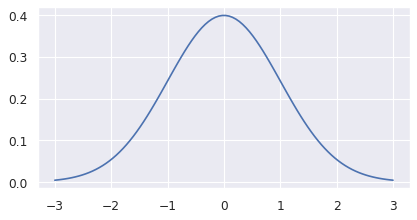

In [5]:
plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
x = np.linspace(-3.0,3.0,100)
y = stats.norm(0,1).pdf(x)
ax.plot(x,y);

In this case the probability distribution function can actually be given as a mathematical function:

$\displaystyle
\frac{1}{\sqrt{2\pi}\sigma}e^{- \frac{\left(x - \mu\right)^{2}}{2 \sigma^{2}}}
$

But in most cases that is not the case. So what should you do then?

I cannot remember anymore in which source I've read it, but the author said that for probability distributions the "right" representation might actually be collections of samples.

Let's look at a toy example. We sample 1000 values from a normal distribution with mean 0 and standard deviation 1. Then we act as if we would only know that the samples are from a normal distribution, but mu and sigma would be unknown. In PyMC3 this example looks like that:

In [6]:
samples = stats.norm(0,1).rvs([1000])

with pm.Model() as model:
    mu = pm.Normal("mu", 0.0, 10.0)
    sigma = pm.Gamma('sigma', alpha=3.0, beta=1.0)
    x = pm.Normal("x", mu=mu, sigma=sigma, observed=samples)
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/home/local/cs/local/install/anaconda3-2021.05-Linux-x86_64/envs/py38ds/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


Just as a reminder and to make the link to what we said above about the model let's be explicit and give the probability distribution function in sympy for two data-points instead of the 1000 from above. All that PyMC3 does is to construct such a total probability distribution function and evaluate it at the given data-points. So in our example $x_1$ and $x_2$ are given and $\mu$ and $\sigma$ are "free" variables.

As another remark: the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is sometimes parametrized via $\alpha, \beta$ and sometimes via $k, \theta$: $\alpha = k; \beta=1/\theta$

In [7]:
smu, sx = sympy.symbols(r'\mu x')
sx1, sx2 = sympy.symbols(r'x1:3')
ssigma = sympy.Symbol("\sigma", positive=True)

prior_mu = sympy.stats.crv_types.NormalDistribution(0, 10).pdf(smu)
prior_sigma = sympy.stats.crv_types.GammaDistribution(3, 1).pdf(ssigma)
likelihood = sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx2)
total = sympy.UnevaluatedExpr(prior_mu)*sympy.UnevaluatedExpr(prior_sigma)*sympy.UnevaluatedExpr(likelihood)
total

(sqrt(2)*exp(-\mu**2/200)/(20*sqrt(pi)))*(\sigma**2*exp(-\sigma)/2)*(exp(-(-\mu + x1)**2/(2*\sigma**2))*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*pi*\sigma**2))

PyMC3 created a trace object containing samples of the "free"/unknown variables. We can look at them as follows:

In [8]:
trace_df = trace['posterior'].to_dataframe()
trace_df

mu     sigma
chain draw                    
0     0    -0.025535  0.995429
      1    -0.000475  0.982951
      2     0.036382  0.960661
      3     0.069528  0.960479
      4     0.052084  0.957739
...              ...       ...
3     995   0.014148  1.015268
      996  -0.010790  0.948807
      997   0.061342  1.008478
      998   0.041587  1.006843
      999   0.046756  0.997424

[4000 rows x 2 columns]

If we would want to know $\mu$ and $\sigma$ we could take the mean:

In [9]:
trace_df.mean().to_frame()

0
mu     0.019798
sigma  0.981421

There is a built-in PyMC3 method that gives us more details in addition to the mean values:

In [10]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
mu     0.020  0.031  -0.038    0.074      0.001      0.0    3294.0    3168.0    1.0
sigma  0.981  0.023   0.941    1.024      0.000      0.0    3464.0    2734.0    1.0

The *hdi* stands for [Highest (Posterior) Density Interval](https://en.wikipedia.org/wiki/Credible_interval) and gives you the range in which credible values are located. As you can see our real values 0.0 for $\mu$ and 1.0 for $\sigma$ are within those hdi invervals.

To get a better idea of the plausible parameter values we'll have a look at a [density plot](https://www.statsmodels.org/stable/examples/notebooks/generated/kernel_density.html).

In [11]:
# list(statsmodels.nonparametric.kde.kernel_switch.keys())

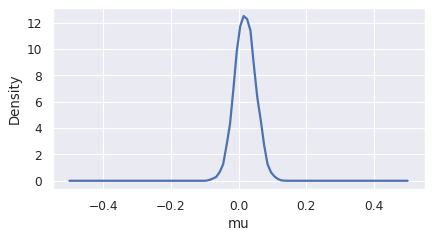

In [12]:
def kdeplot(lds, parameter_name=None, x_min = None, x_max = None, ax=None, kernel='gau'):
    if parameter_name is None and isinstance(lds, pd.Series):
        parameter_name = lds.name
    kde = sm.nonparametric.KDEUnivariate(lds)
    kde.fit(kernel=kernel, fft=False, gridsize=2**10)
    if x_min is None:
        x_min = kde.support.min()
    else:
        x_min = min(kde.support.min(), x_min)
    if x_max is None:
        x_max = kde.support.max()
    else:
        x_max = max(kde.support.max(),  x_max)
    x = np.linspace(x_min, x_max,100)
    y = kde.evaluate(x)
    if ax is None:
        plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
        ax = plt.subplot(1, 1, 1)
    ax.plot(x, y, lw=2)
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('Density')
    
kdeplot(trace_df['mu'], x_min=-0.5, x_max=0.5)

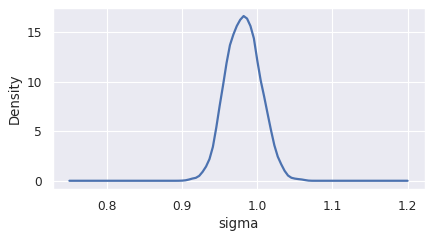

In [13]:
kdeplot(trace_df['sigma'], x_min=0.75, x_max=1.2)

We will talk about it in more detail below, but what we did above is that we looked at the marginal likelihood of only $\mu$ or only $\sigma$. If your probability density function is given as samples then marginalzing out other parameters is trivial. You only take the parameter(s) (the columns in the sample dataframe) you're interested in.

It is important to understand that the samples, e.g. each row in the sample dataframe, are **jointly plausible**, e.g. they represent the joint probability distribution. If two parameters would be correlated you would see that in the pairsplot like below. In our example the two parameters are obviously uncorrelated.

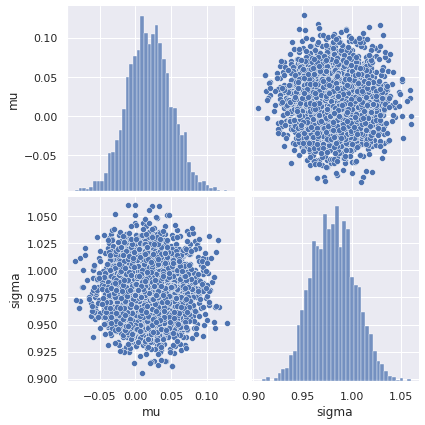

In [14]:
sns.pairplot(trace_df, height=3);

## Operations on probability distributions: marginalization and conditional probability

While the marginalization and conditional probability operations are quite involved when you deal with probability distributions in the form of mathematical functions these operations are trivial! if you have samples representing the probability distributions.

Let's start with marginalization. Let's assume you have a joint probability distribution function $p(x,y)$ for two random variables $X$ and $Y$. Then you marginalize out $y$ be integrating over all values of $y$:

$
\displaystyle
\begin{array}{rcl}
p(x)&=&\displaystyle\int p(x,y)\,\mathrm{d}y
\end{array}
$

This integration may be quite involved even in simple cases like a [multi-variate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Have a look at [Bayes’ Theorem for Gaussians](http://web4.cs.ucl.ac.uk/staff/C.Bracegirdle/bayesTheoremForGaussians.pdf) by Chris Bracegirdle for details.

In the case of samples marginalization is *trivial*! You simply sub-select the column(s) you're interested in and you get the marginal distribution for that parameter set.

The conditional probability is defined as:

$
\displaystyle
\begin{array}{rcl}
p(x,y)&=&\displaystyle p(y\,|\, x)p(x) \\
\Rightarrow p(y\,|\, x=x_0)&=&\displaystyle \frac{p(x_0,y)}{p(x_0)}\\
&=&\displaystyle \frac{p(x=x_0,y)}{\int p(x=x_0,y)\mathrm{d}y} \text{ you simply normalize the function } p(x=x_0,y)
\end{array}
$

You have to divide two distributions. I also show the variation where you use the marginalization $\int p(x=x_0,y)\mathrm{d}y$, because sometimes that's useful to remember. $p(x=x_0,y)$ is no probability distribution in $y$ any longer, because $\int p(x=x_0,y)\mathrm{d}y < 1$.

If you deal with samples then the conditional probability is calculated like an SQL *where* clause, e.g. you sub-select the dataframe for values where $x=x_0$. For continuous variables this condition is nearly never true. Therefore you have to sub-select with a *where* condition like $x_0-\delta<x<x_0+\delta$. Finally you only keep the columns (SQL projection) of the variables that are on the left hand side of the conditional probability bar ($(\cdot\,|\,\cdot)$), e.g. $y$ in our example.

## Calculations with random variables: convolutions and other nasty stuff

Calculating with random variables when their distribution is given as mathematical functions is just painfully difficult. The book [The algebra of random variables](https://www.amazon.com/algebra-variables-probability-mathematical-statistics/dp/0471014060) by Melvine Dale Springer gives a detailed overview. But even the simplest example like adding two random variables like $X=X_1+X_2$ where $X_1\sim p_1(x_1)$ and $X_2\sim p_2(x_2)$ involves [convolutions](https://en.wikipedia.org/wiki/Convolution), e.g. $X\sim p(x)= \int p_1(x-x_2)p_2(x_2)\,\mathrm{d}x_2$. The library [PaCal](https://github.com/jszymon/pacal) (ProbAbilistic Calculator) or [SymPy](https://docs.sympy.org/latest/modules/stats.html) may help. Nevertheless it is just best to avoid these intricate calculations completely.

Luckily, in the world of samples, all of that is simple again! Imagine you have a distribution given as samples from $x_1$ and $x_2$. You then construct samples of $x_1+x_2$ by simply adding them up for every row in your samples dataframe, e.g. $x = x_1 + x_2$. And there you are, you have samples of the random variable $X$!

Another example might be like above, like when we calculated the trajectory of the ball. You could also see that example as $X_1 = X_0 + \Delta X$, where $\Delta X$ would be a distribution depending on the time delta $t_1-t_2$, the velocity $v$ and the acceleration $g$. In such cases it is typically easiest to see one of the variables as the starting point, e.g. $X_0$ and then use the law of total probability to construct $p(x_0, x_1)=p(x_0)p(x_1\,|\,x_0)$ and then calculate on the "conditional" side of $p(x_1\,|\,x_0)$, e.g. 

$
\displaystyle
p(x_1\,|\,x_0) = \mathcal{N}(x_0+v(t_1-t_0)+(g/2)(t_1-t_0)^2,\sigma_m)
$

As you can see, on the "conditional" side of $p(x_1\,|\,x_0)$ (the side involving $x_0$) we simply calculate like normal! We simply add, subtract, multiply and whatever else we want to do. We also avoid the convolution by sampling from the total joint probability distribution $p(x_0, x_1)$ and marginalizing on the samples by simply dropping the $x_0$ column if we really wanted to. **No convolutions and no other difficult operations on distributions**! Just normal math and sampling on the extended joint space.

## Density Estimation

In the past, whenever I was dealing with machine learning methods, I always felt disappointed, disappointed about the lack of "insight" and "understanding" and that machine learning methods only give me a uni-directional way of reasoning.

Let's take regression or classification for example. Even the recent really impressive success stories like [object detection](https://en.wikipedia.org/wiki/Object_detection) and [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) give you a way from an input to an output. If you wanted to know the most distinguishing features of a dog vs. a cat you're immediately out of luck.

In my first encounter with [Bayesian networks](https://en.wikipedia.org/wiki/Bayesian_network) I was so impressed with the fact that you can not only reason forward from disease to symptoms, but also backward like given the symptoms of a patient, what are the most likely root causes, e.g. which disease might be the root cause and which actions/medicaments might be the best way forward.

It took me quite some time to understand "what I really wanted". I wanted "all the answers", not only partial answers. And again some more time went by until I found the "term" that refers to what I want: [density estimation](https://en.wikipedia.org/wiki/Density_estimation). This term is often accompanied by other terms like [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) and recent advances in machine learning are also targeting density estimation directly via [deep generative models](https://en.wikipedia.org/wiki/Generative_model#Deep_generative_models). In the end it all boils down to "discovering" the [causal network](https://en.wikipedia.org/wiki/Causal_model) of the world, so that in the end you can answer any question you'd come up with, not only the ones the designer of the "system" wanted you to ask.

## The algorithm has to always perform the same heavy lifting: there is no ancestral sampling

When I read the paper [Mixed Hamiltonian Monte Carlo for Mixed Discrete and Continuous Variables](https://arxiv.org/abs/1909.04852) by Guangyao Zhou he used an exmaple of a [24 dimensional Gaussian Mixture Model](https://github.com/StannisZhou/mixed_hmc/blob/master/momentum/potential/simple_gmm.py) **without observations** to show the power of his approach. Initially I felt as if this was cheating, because in the end [forward/ancestral](https://ermongroup.github.io/cs228-notes/inference/sampling) sampling is trival in that case. I had to remind myself that the MCMC algorithm he invented has to perform the same heavy lifting in the given example without observations as it has to perform in a situation that involves observations and the same number of free variables. The probabilistic programming languages and frameworks like [Stan](https://mc-stan.org/) or [PyMC3](https://docs.pymc.io/) do not employ any additional intelligence to decide which method might be most appropriate in which case.

> You always take a model in the form of a scalar valued function representing the (unnormalized) total probability function and then you always apply the same hammer like an [SMC](https://www.amazon.com/-/de/dp-0387951466/dp/0387951466/) or [MCMC](https://www.amazon.com/-/de/dp-B008GXJVF8/dp/B008GXJVF8/) algorithm.

If you want to be smart on that level you have to do it yourself as a human with your own brain.

## Appendix

### Examples of mixed discrete continuous probability functions

Below I am exaggerating the level of being explicite about each step and the level at which I use [sympy](https://www.sympy.org/en/index.html) to achieve this explicitness. I hope that this will help you from suffering a similar level of confusion that I found myself in. In addition you might learn to appreciate to use *sympy*, which is really great for symbolic algebra.

#### Two independent dice rolls 

The first one is what we currently look at: independent dice throws. Let's look at two independent dice throws where we don't know $\theta\in[0,1]$: $p(d_1,d_2,\theta)=p(X_0=d_0\,|\,\theta)\cdot p(X_1=d_1\,|\,\theta)\cdot p(\theta)$. If we take $p(\theta)=\mathrm{Beta}(1,1)=1$ for $\theta\in[0,1]$ we get for each dice a one dimensional matrix with two entries:

In [15]:
stheta = sympy.var(r'\theta')
D1 = sympy.Matrix([[(1-stheta)], [stheta]])
D1

Matrix([
[1 - \theta],
[    \theta]])

Where the entry with index 0 is the case where we receive "tail" and where the entry with index 1 is the case where we receive "head". We can index into that vector:

In [16]:
display(D1[0]),display(D1[1]);

1 - \theta

\theta

For the second dice we take a 2x1 matrix, so that when we multiply the two we will get a 2x2 matrix for the 2x2 combinations of tail and head for each coin:

In [17]:
D2 = sympy.Matrix([[(1-stheta), stheta]])
D = D1*D2
D

Matrix([
[    (1 - \theta)**2, \theta*(1 - \theta)],
[\theta*(1 - \theta),           \theta**2]])

We said above that a probability function needs to be a function that takes as arguments the values of all random variables and delivers a scalar. In python this would look like:

In [18]:
def two_dice_roll_probability_function(theta, d1, d2):
    v = D.subs(stheta, theta)
    v = v[d1,d2] # we use indexing to access a concrete slot in the multi dimensional array
    return v

If we then wanted to know the probability of one head and one tail for a fair coin we would get:

In [19]:
theta = sympy.Integer(1)/2
display(theta)
two_dice_roll_probability_function(theta, 1, 0)

1/2

1/4

The other way we could have done it would be by the use of the [Kronecker_delta](https://en.wikipedia.org/wiki/Kronecker_delta) and using the fact that any number to the power of $0$ is $1$: $x^0=1$, e.g. the neutral element of our product of probability functions.

In [20]:
sd1, sd2 = sympy.symbols('d1:3') # we define two new sympy symbols for d1 and d2
sd1, sd2

(d1, d2)

Below the first $1$ is to remind us of the $p(\theta)=\mathrm{Beta}(1,1)=1$. In case that we used another prior this would be a different factor.

In [21]:
D_ = 1*(1-stheta)**sympy.KroneckerDelta(0,sd1)*stheta**sympy.KroneckerDelta(1,sd1)*(1-stheta)**sympy.KroneckerDelta(0,sd2)*stheta**sympy.KroneckerDelta(1,sd2)
D_

\theta**KroneckerDelta(1, d1)*\theta**KroneckerDelta(1, d2)*(1 - \theta)**KroneckerDelta(0, d1)*(1 - \theta)**KroneckerDelta(0, d2)

In [22]:
def two_dice_roll_probability_function_(theta, d1, d2):
    v = D_.subs(stheta, theta)
    v = v.subs(sd1,d1)
    v = v.subs(sd2,d2)
    return v

And of course you get the same result:

In [23]:
two_dice_roll_probability_function(theta, 1, 0)

1/4

The Kronecker delta variant looks more like a function, but a computer works better with an index lookup in a matrix. Finally we could use an **if-then-else** structure, but many probabilistic programming environments behave clumsy when it comes to if-then-else constructs.

#### Two component mixture model

The second example is a two component mixture model. In most cases people will show a mixture of two Gaussians, but with two Gaussians you can get away with using an array of $\mu$ and $\sigma$. Let's look at mixing one Gaussian with one Exponential distribution:

In [24]:
smu, sx = sympy.symbols(r'\mu x')
sx1, sx2 = sympy.symbols(r'x1:3')
si, sj = sympy.symbols('i j', integer=True)
sp0, sp1 = sympy.symbols(r'p:2')
ssigma = sympy.Symbol("\sigma", positive=True)
slambda = sympy.Symbol("\lambda", positive=True)
sympy.Matrix([smu, ssigma, slambda, sx, sx1, sx2, si, sj, sp0, sp1]).T # just for displaying the symbols

Matrix([[\mu, \sigma, \lambda, x, x1, x2, i, j, p0, p1]])

In [25]:
sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx)

sqrt(2)*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma)

In [26]:
sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx)

\lambda*exp(-\lambda*x)

For the mixture to work we use a mixture indicator $i\in\{0,1\}$. If $i$ is 0 then we draw from the Exponential distribution and when $i$ is 1 we draw from the normal distribution. 

In [27]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(sx)

Piecewise((p1, Eq(x, 1)), (1 - p1, Eq(x, 0)), (0, True))

In [28]:
print(sympy.latex(sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(sx)))

\begin{cases} p_{1} & \text{for}\: x = 1 \\1 - p_{1} & \text{for}\: x = 0 \\0 & \text{otherwise} \end{cases}


In [29]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)

p1

In [30]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)

1 - p1

$
\displaystyle
p(p_1,i,\lambda,\mu,\sigma,x)=p(p_1)p(i\,|\,p_1)\begin{cases}p(\lambda)p(x\,|\,\lambda) & \text{for}\: i = 0\\ p(\mu)p(\sigma)p(x\,|\,\mu,\sigma) & \text{for}\: i = 1 \\0 & \text{otherwise} \end{cases}
$

In [31]:
sprior_exponential = sympy.stats.crv_types.ExponentialDistribution(1).pdf(slambda)
sprior_normal = sympy.stats.crv_types.ExponentialDistribution(1).pdf(ssigma)*sympy.stats.crv_types.NormalDistribution(0, 100).pdf(smu)
sprior_mixture_components = sprior_normal*sympy.stats.crv_types.BetaDistribution(1,1).pdf(sp1)
sprior = sprior_exponential*sprior_normal*sprior_mixture_components
smixture_likelihood = \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx1))**sympy.KroneckerDelta(0,si) * \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx1))**sympy.KroneckerDelta(1,si) * \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx2))**sympy.KroneckerDelta(0,sj) * \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx2))**sympy.KroneckerDelta(1,sj)
smixture = sprior * smixture_likelihood
smixture 

(\lambda*(1 - p1)*exp(-\lambda*x1))**KroneckerDelta(0, i)*(\lambda*(1 - p1)*exp(-\lambda*x2))**KroneckerDelta(0, j)*(sqrt(2)*p1*exp(-(-\mu + x1)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))**KroneckerDelta(1, i)*(sqrt(2)*p1*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))**KroneckerDelta(1, j)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)/(20000*pi)

In [32]:
marginal_likelihood1 = sympy.summation(smixture, (si, 0, 1), (sj, 0, 1))
marginal_likelihood1

(\lambda*(1 - p1)*exp(-\lambda*x1) + sqrt(2)*p1*exp(-(-\mu + x1)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))*(\lambda*(1 - p1)*exp(-\lambda*x2) + sqrt(2)*p1*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)/(20000*pi)

In [33]:
sympy.summation(smixture_likelihood, (si, 0, 1), (sj, 0, 1))

(\lambda*(1 - p1)*exp(-\lambda*x1) + sqrt(2)*p1*exp(-(-\mu + x1)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))*(\lambda*(1 - p1)*exp(-\lambda*x2) + sqrt(2)*p1*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))

In [34]:
M1 = sympy.Matrix([
    sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx1), 
    sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx1)])
M2 = sympy.Matrix([[
    sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx2), 
    sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx2)]])
M = M1 * M2
E = sprior * sympy.UnevaluatedExpr(M)
E

exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*Matrix([
[                                           \lambda**2*(1 - p1)**2*exp(-\lambda*x1)*exp(-\lambda*x2), sqrt(2)*\lambda*p1*(1 - p1)*exp(-\lambda*x1)*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma)],
[sqrt(2)*\lambda*p1*(1 - p1)*exp(-\lambda*x2)*exp(-(-\mu + x1)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma),        p1**2*exp(-(-\mu + x1)**2/(2*\sigma**2))*exp(-(-\mu + x2)**2/(2*\sigma**2))/(2*pi*\sigma**2)]])/(20000*pi)

In [35]:
E_ = E.doit()

In [36]:
E_[0,0]

\lambda**2*(1 - p1)**2*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x1)*exp(-\lambda*x2)/(20000*pi)

In [37]:
marginal_likelihood2 = sympy.Add(*[E_[i, j] for i in range(2) for j in range(2)])
marginal_likelihood2

\lambda**2*(1 - p1)**2*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x1)*exp(-\lambda*x2)/(20000*pi) + sqrt(2)*\lambda*p1*(1 - p1)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x2)*exp(-(-\mu + x1)**2/(2*\sigma**2))/(40000*pi**(3/2)*\sigma) + sqrt(2)*\lambda*p1*(1 - p1)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x1)*exp(-(-\mu + x2)**2/(2*\sigma**2))/(40000*pi**(3/2)*\sigma) + p1**2*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-(-\mu + x1)**2/(2*\sigma**2))*exp(-(-\mu + x2)**2/(2*\sigma**2))/(40000*pi**2*\sigma**2)

In [38]:
sympy.simplify(marginal_likelihood1 - marginal_likelihood2)

0